In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import zipfile

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
source_path = '/content/drive/My Drive/SOI_SDS'

In [5]:
destination_folder = '/content/zip'

In [ ]:
import shutil
shutil.copytree(source_path, destination_folder)

In [11]:
import zipfile
zip_ref = zipfile.ZipFile("/content/zip/train_dataset.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [12]:
df = pd.read_csv('/content/drive/My Drive/SOI_SDS/train.csv')
df.head()

,File Name,Class
0,1.jpg,other
1,2.jpg,bright dune
2,3.jpg,other
3,4.jpg,crater
4,5.jpg,other


In [13]:
df.columns

Index(['File Name', 'Class'], dtype='object')

In [14]:
df['Class'].unique()

array(['other', 'bright dune', 'crater', 'slope streak', 'dark dune',
       'swiss cheese', 'spider', 'impact ejecta'], dtype=object)

In [15]:
import os
image_directory = '/content/train_dataset'
df['File Name'] = df['File Name'].apply(lambda x: os.path.join(image_directory, x))

In [16]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def view_random_images(df, num_images=4):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for ax in axs.flat:
        random_iloc = random.randint(0, len(df) - 1)
        random_image = df['File Name'][random_iloc]
        img = mpimg.imread(random_image)
        ax.imshow(img, cmap='gray')
        ax.set_title(df['Class'][random_iloc])
        ax.axis("off")
        print(f"Image shape: {img.shape}")
    plt.tight_layout()
    plt.show()

Image shape: (227, 227)
Image shape: (227, 227)
Image shape: (227, 227)
Image shape: (227, 227)


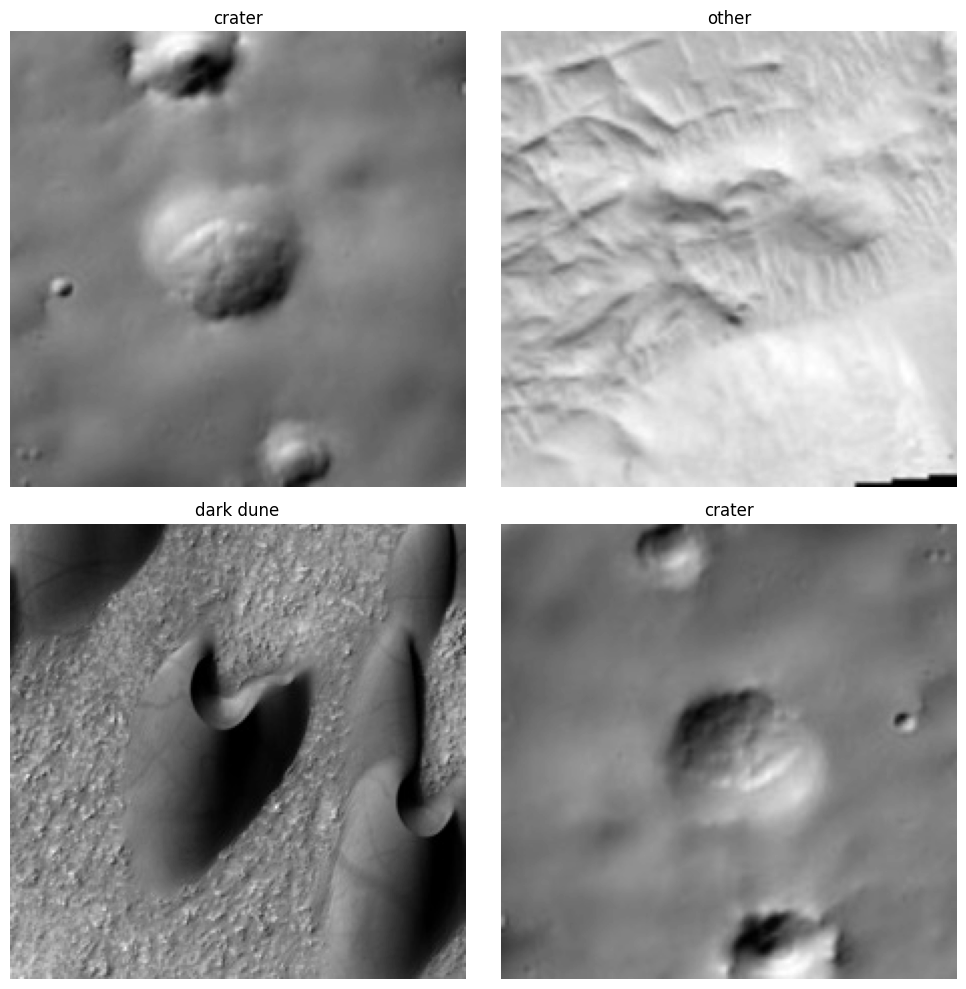

In [17]:
view_random_images(df)

In [18]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=1)

In [19]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

In [20]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [21]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='File Name',
    y_col='Class',
    target_size=(227, 227),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64,
    shuffle=True
)

Found 5580 validated image filenames belonging to 8 classes.


In [22]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='File Name',
    y_col='Class',
    target_size=(227, 227),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 621 validated image filenames belonging to 8 classes.


VGG16 Model

In [23]:
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(227, 227, 3))

In [24]:
for layer in base_model.layers:
    layer.trainable = False   # Freeze

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', input_shape=(227, 227, 1)),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, activation='softmax')
])

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 227, 227, 3)       30        
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 21139558 (80.64 MB)
Trainable params: 6424

In [28]:
history = model.fit(
    train_images,
    epochs=10,
    steps_per_epoch=len(train_images),
    validation_data=test_images,
    validation_steps=len(test_images),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/10
88/88 [==============================] - 103s 818ms/step - loss: 1.6463 - accuracy: 0.5627 - val_loss: 1.0403 - val_accuracy: 0.6457 - lr: 0.0010
Epoch 2/10
88/88 [==============================] - 57s 647ms/step - loss: 1.0057 - accuracy: 0.6821 - val_loss: 0.8273 - val_accuracy: 0.7456 - lr: 0.0010
Epoch 3/10
88/88 [==============================] - 54s 610ms/step - loss: 0.8675 - accuracy: 0.7151 - val_loss: 0.6933 - val_accuracy: 0.7649 - lr: 0.0010
Epoch 4/10
88/88 [==============================] - 55s 619ms/step - loss: 0.8038 - accuracy: 0.7364 - val_loss: 0.6649 - val_accuracy: 0.7713 - lr: 0.0010
Epoch 5/10
88/88 [==============================] - 55s 618ms/step - loss: 0.7387 - accuracy: 0.7468 - val_loss: 0.6514 - val_accuracy: 0.7762 - lr: 0.0010
Epoch 6/10
88/88 [==============================] - 55s 618ms/step - loss: 0.7075 - accuracy: 0.7622 - val_loss: 0.6271 - val_accuracy: 0.7794 - lr: 0.0010
Epoch 7/10
88/88 [==============================] - 54s 606ms/s

In [39]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.47159
Test Accuracy: 83.74%


In [47]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

In [56]:
import zipfile
zip_ref = zipfile.ZipFile("/content/zip/test_dataset.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [57]:
test_image_directory = '/content/test_dataset'
csv_output_path = '/content/drive/My Drive/SOI_SDS/predictions_VGG16.csv'

In [58]:
img_size = (227,227,1)

In [60]:
class_labels = list(test_images.class_indices.keys())

In [61]:
image_paths = []
predicted_labels = []

In [62]:
for img_file in os.listdir(test_image_directory):
    img_path = os.path.join(test_image_directory, img_file)

    img = image.load_img(img_path, target_size=img_size, color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions[0])
    predicted_label = class_labels[predicted_index]

    image_paths.append(img_path)
    predicted_labels.append(predicted_label)


1/1 [==============================] - 0s 23ms/step


In [63]:
results_df = pd.DataFrame({
    'Image_Path': image_paths,
    'Predicted_Label': predicted_labels
})

In [64]:
results_df.to_csv(csv_output_path, index=False)

RESNET Model

In [73]:
df = pd.read_csv('/content/drive/My Drive/SOI_SDS/train.csv')
df.head()

,File Name,Class
0,1.jpg,other
1,2.jpg,bright dune
2,3.jpg,other
3,4.jpg,crater
4,5.jpg,other


In [74]:
import os
image_directory = '/content/train_dataset'
df['File Name'] = df['File Name'].apply(lambda x: os.path.join(image_directory, x))

Image shape: (227, 227)
Image shape: (227, 227)
Image shape: (227, 227)
Image shape: (227, 227)


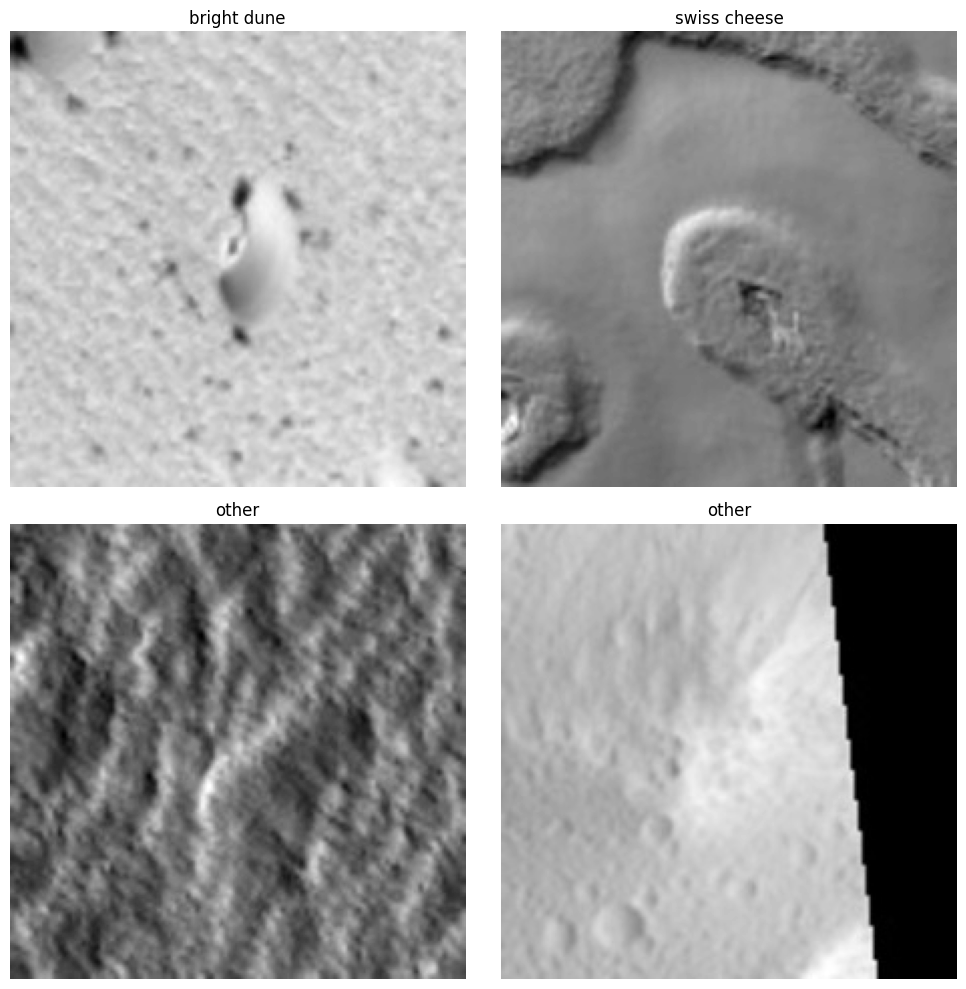

In [75]:
view_random_images(df)

In [1]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=1)

NameError: name 'train_test_split' is not defined

In [82]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

train_images = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='File Name',
    y_col='Class',
    target_size=(227, 227),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True
)

test_images = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='File Name',
    y_col='Class',
    target_size=(227, 227),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 5580 validated image filenames belonging to 8 classes.
Found 621 validated image filenames belonging to 8 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential

base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(227, 227, 3))

for layer in base_model.layers:
    layer.trainable = False   # Freeze

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(
    train_images,
    epochs=10,
    steps_per_epoch=len(train_images),
    validation_data=test_images,
    validation_steps=len(test_images),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3)
    ]
)


Epoch 1/10
